In [7]:
# 일반 버전 (복잡도 고려, no stop)

import pandas as pd
import numpy as np
import math
from datetime import datetime

# <Sets>
customers = pd.DataFrame(columns=["customer_id", "longitude", "latitude", "deadline"])
stops = pd.DataFrame(columns=["stop_id", "longitude", "latitude"])
ADRs = pd.DataFrame(columns=["ADR_id"])
grid_cells = pd.DataFrame(columns=["grid_cell_id", "center_longitude", "center_latitude", "complexity"])
terminals = pd.DataFrame(columns=["terminal_id", "longitude", "latitude"])

# 예시 데이터 삽입
np.random.seed(1)

for i in range(1, 3):
    lon = np.random.uniform(0, 100)
    lat = np.random.uniform(0, 100)
    # deadline = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    deadline = np.random.uniform(50, 100)
    customers.loc[len(customers)] = [f"customer_{i}", lon, lat, deadline]

number_of_stops = 7
for i in range(1, number_of_stops + 1):
    lon = np.random.uniform(0, 100)
    lat = np.random.uniform(0, 100)
    stops.loc[len(stops)] = [f"stop_{i}", lon, lat]

for i in range(1, 2):
    lon = np.random.uniform(0, 80)
    lat = np.random.uniform(100, 120)
    terminals.loc[len(terminals)] = [f"terminal_{i}", lon, lat]

cell_size = 20  # 반경 10 → 한 변 20
grid_cell_id = 1
for i in range(0, 100, cell_size):
    for j in range(0, 100, cell_size):
        center_lon = i + cell_size / 2
        center_lat = j + cell_size / 2
        complexity = np.random.uniform(0.1, 1.0)
        grid_cells.loc[len(grid_cells)] = [f"grid_cell_{grid_cell_id}", center_lon, center_lat, complexity]
        grid_cell_id += 1

for i in range(1, 20):
    ADRs.loc[len(ADRs)] = [f"ADR_{i}"]

customers.set_index("customer_id", inplace=True)
stops.set_index("stop_id", inplace=True)
ADRs.set_index("ADR_id", inplace=True)
grid_cells.set_index("grid_cell_id", inplace=True)
terminals.set_index("terminal_id", inplace=True)

# <Parameters>
ALPHA = 0.2
BETA = 0.2
VELOCITY_OF_TRUCK = 30 # V_t
VELOCITY_OF_ADR = 5 # V_r
CAPACITY_OF_TRUCK = 30 # Cap_t
def get_deadline(customer_id): # D_c
    return customers.loc[customer_id]['deadline']
def get_complexity(grid_cell_id): # Comp_p
    return grid_cells.loc[grid_cell_id]['complexity']
def get_distance_with_p(stop_id, customer_id, grid_cell_id): # d_ic_p
    # 좌표
    x1, y1 = stops.loc[stop_id][["longitude", "latitude"]]
    x2, y2 = customers.loc[customer_id][["longitude", "latitude"]]
    
    # grid cell 범위
    cell_size = 20
    cx, cy = grid_cells.loc[grid_cell_id][["center_longitude", "center_latitude"]]
    half = cell_size / 2
    xmin, xmax = cx - half, cx + half
    ymin, ymax = cy - half, cy + half

    # Liang-Barsky line clipping
    dx, dy = x2 - x1, y2 - y1
    p = [-dx, dx, -dy, dy]
    q = [x1 - xmin, xmax - x1, y1 - ymin, ymax - y1]

    u1, u2 = 0, 1
    for pi, qi in zip(p, q):
        if pi == 0:
            if qi < 0:
                return 0  # 평행 & 영역 밖
        else:
            t = qi / pi
            if pi < 0:
                u1 = max(u1, t)
            else:
                u2 = min(u2, t)

    if u1 > u2:  # 교차 없음
        return 0

    # 잘린 선분 좌표
    ix1, iy1 = x1 + u1 * dx, y1 + u1 * dy
    ix2, iy2 = x1 + u2 * dx, y1 + u2 * dy

    # 교차 구간 길이
    return math.sqrt((ix2 - ix1) ** 2 + (iy2 - iy1) ** 2)
def get_distance_from_stop_to_stop(from_stop_id, to_stop_id): # d_ij
    # Manhattan distance
    # return abs(stops.loc[from_stop_id]['longitude'] - stops.loc[to_stop_id]['longitude']) \
    #     + abs(stops.loc[from_stop_id]['latitude'] - stops.loc[to_stop_id]['latitude'])

    # Euclidean distance
    return math.sqrt((stops.loc[from_stop_id]['longitude'] - stops.loc[to_stop_id]['longitude']) ** 2
                     + (stops.loc[from_stop_id]['latitude'] - stops.loc[to_stop_id]['latitude']) ** 2)
def get_distance_from_terminal_to_stop(terminal_id, stop_id): # d_oj
    return math.sqrt((terminals.loc[terminal_id]['longitude'] - stops.loc[stop_id]['longitude']) ** 2
                     + (terminals.loc[terminal_id]['latitude'] - stops.loc[stop_id]['latitude']) ** 2)
def get_distance_from_stop_to_terminal(stop_id, terminal_id): # d_io
    return math.sqrt((stops.loc[stop_id]['longitude'] - terminals.loc[terminal_id]['longitude']) ** 2
                     + (stops.loc[stop_id]['latitude'] - terminals.loc[terminal_id]['latitude']) ** 2)
DROP_OFF_TIME = 0.5 # T_d
PICKUP_TIME = 1.0 # T_p
ADR_TIME = 0.3 # T_r
NUMBER_OF_CUSTOMERS = len(customers) # N_c
M = 10 ** 5

import gurobipy as gp
from gurobipy import GRB, quicksum

model = gp.Model('Last-mile Logistics with Two Trucks and ADRs')

# Decision variables
x_ij_d = model.addVars(terminals.index.tolist() + stops.index.tolist(), terminals.index.tolist() + stops.index.tolist(), vtype=GRB.BINARY, name="x_ij_d")
x_ij_p = model.addVars(terminals.index.tolist() + stops.index.tolist(), terminals.index.tolist() + stops.index.tolist(), vtype=GRB.BINARY, name="x_ij_p")
y_ic_r = model.addVars(stops.index.tolist(), customers.index.tolist(), ADRs.index.tolist(), vtype=GRB.BINARY, name="y_ic_r")
y_cj_r = model.addVars(customers.index.tolist(), stops.index.tolist(), ADRs.index.tolist(), vtype=GRB.BINARY, name="y_cj_r")

# Arbitrary variables
t_j_d = model.addVars(terminals.index.tolist() + stops.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="t_j_d")
t_j_p = model.addVars(terminals.index.tolist() + stops.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="t_j_p")
t_c_r = model.addVars(customers.index.tolist(), ADRs.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="t_c_r")

# Auxiliary variable
z_c_r = model.addVars(customers.index.tolist(), ADRs.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="z_c_r")

# Objective
# penalty_cost
penalty_cost = quicksum(z_c_r[c, r] for c in customers.index.tolist() for r in ADRs.index.tolist())
# trucks travel cost
trucks_travel_cost = quicksum(get_distance_from_stop_to_stop(i, j) * (x_ij_d[i, j] + x_ij_p[i, j]) 
                              for i in stops.index.tolist() for j in stops.index.tolist()) + \
                    quicksum(get_distance_from_terminal_to_stop(i, j) * (x_ij_d[i, j] + x_ij_p[i, j]) 
                             for i in terminals.index.tolist() for j in stops.index.tolist()) + \
                    quicksum(get_distance_from_stop_to_terminal(i, j) * (x_ij_d[i, j] + x_ij_p[i, j]) 
                             for i in stops.index.tolist() for j in terminals.index.tolist())
# ADRs travel cost
stop_to_customer = quicksum(y_ic_r[i, c, r] * get_distance_with_p(i, c, p)
                        for i in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist() for p in grid_cells.index.tolist())
customer_to_stop = quicksum(y_cj_r[c, j, r] * get_distance_with_p(j, c, p)
                        for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist() for p in grid_cells.index.tolist())
ADRs_travel_cost = stop_to_customer + customer_to_stop

model.setObjective(penalty_cost + ALPHA * trucks_travel_cost + BETA * ADRs_travel_cost, GRB.MINIMIZE)

# Constraints
model.addConstrs(z_c_r[c, r] >= t_c_r[c, r] - get_deadline(c) for c in customers.index.tolist() for r in ADRs.index.tolist()) # 2

model.addConstrs(quicksum(x_ij_d[i, j] for j in terminals.index.tolist() + stops.index.tolist()) <= 1 # 3
                 for i in terminals.index.tolist() + stops.index.tolist())

model.addConstrs(quicksum(x_ij_p[i, j] for j in terminals.index.tolist() + stops.index.tolist()) <= 1 # 4
                 for i in terminals.index.tolist() + stops.index.tolist())

model.addConstr(quicksum(x_ij_d[o, j] for o in terminals.index.tolist() for j in stops.index.tolist()) == 1) # 5

model.addConstr(quicksum(x_ij_p[o, j] for o in terminals.index.tolist() for j in stops.index.tolist()) == 1) # 6

model.addConstr(quicksum(x_ij_d[i, o] for i in stops.index.tolist() for o in terminals.index.tolist()) == 1) # 7

model.addConstr(quicksum(x_ij_p[i, o] for i in stops.index.tolist() for o in terminals.index.tolist()) == 1) # 8

model.addConstrs(quicksum(x_ij_d[i, j] for i in terminals.index.tolist() + stops.index.tolist() if i != j) == # 9
                 quicksum(x_ij_d[j, k] for k in terminals.index.tolist() + stops.index.tolist() if k != j)
                 for j in stops.index.tolist())

model.addConstrs(quicksum(x_ij_p[i, j] for i in terminals.index.tolist() + stops.index.tolist() if i != j) == # 10
                 quicksum(x_ij_p[j, k] for k in terminals.index.tolist() + stops.index.tolist() if k != j)
                 for j in stops.index.tolist())

model.addConstr(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist()) # 11
                <= CAPACITY_OF_TRUCK)

model.addConstrs(quicksum(y_ic_r[i, c, r] for c in customers.index.tolist() for r in ADRs.index.tolist()) >= # 12
                 quicksum(x_ij_d[j, i] for j in terminals.index.tolist() + stops.index.tolist() if i != j)
                 for i in stops.index.tolist())

model.addConstrs(quicksum(x_ij_p[i, j] for i in terminals.index.tolist() + stops.index.tolist() if i != j) >= # 13
                 quicksum(y_cj_r[c, j, r] for c in customers.index.tolist() for r in ADRs.index.tolist()) / NUMBER_OF_CUSTOMERS
                 for j in stops.index.tolist())

model.addConstrs(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist()) == # 14
                 quicksum(y_cj_r[c, j, r] for j in stops.index.tolist())
                 for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist() for r in ADRs.index.tolist()) == 1 # 15
                 for c in customers.index.tolist())

model.addConstrs(t_j_d[o] == 0 for o in terminals.index.tolist()) # 16

model.addConstrs(t_j_d[j] >= t_j_d[o] + get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK # 17-1
                 + DROP_OFF_TIME
                 - M * (1 - x_ij_d[o, j])
                 for o in terminals.index.tolist() for j in stops.index.tolist())
model.addConstrs(t_j_d[j] >= t_j_d[i] + get_distance_from_stop_to_stop(i, j) / VELOCITY_OF_TRUCK # 17-2
                 + DROP_OFF_TIME
                 - M * (1 - x_ij_d[i, j])
                 for i in stops.index.tolist() for j in stops.index.tolist())

# 도로 복잡도를 고려하는 경우
model.addConstrs(t_c_r[c, r] >= t_j_d[i] # 18
                 + quicksum(get_distance_with_p(i, c, p) / VELOCITY_OF_ADR / get_complexity(p) for p in grid_cells.index.tolist())
                 + ADR_TIME
                 - M * (1 - y_ic_r[i, c, r])
                 for i in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[o] <= t_c_r[c, r] # 19
                 + quicksum(get_distance_with_p(j, c, p) / VELOCITY_OF_ADR / get_complexity(p) for p in grid_cells.index.tolist())
                 - get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK
                 + M * (1 - y_cj_r[c, j, r])
                 for o in terminals.index.tolist() for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[o] >= t_c_r[c, r] # 20
                 + quicksum(get_distance_with_p(j, c, p) / VELOCITY_OF_ADR / get_complexity(p) for p in grid_cells.index.tolist())
                 - get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK
                 - M * (1 - y_cj_r[c, j, r])
                 for o in terminals.index.tolist() for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[j] >= t_c_r[c, r] # 21
                 + quicksum(get_distance_with_p(j, c, p) / VELOCITY_OF_ADR / get_complexity(p) for p in grid_cells.index.tolist())
                 + PICKUP_TIME
                 - M * (1 - y_cj_r[c, j, r])
                 for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[j] >= t_j_p[o] # 22-1
                 + get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK
                 + PICKUP_TIME
                 - M * (1 - x_ij_p[o, j])
                 for o in terminals.index.tolist() for j in stops.index.tolist())
model.addConstrs(t_j_p[j] >= t_j_p[i] # 22-2
                 + get_distance_from_stop_to_stop(i, j) / VELOCITY_OF_TRUCK
                 + PICKUP_TIME
                 - M * (1 - x_ij_p[i, j])
                 for i in stops.index.tolist() for j in stops.index.tolist() if i != j)

model.addConstrs(x_ij_d[i, j] + x_ij_d[j, i] <= 1 # 23
                 for i in stops.index.tolist() for j in stops.index.tolist())

model.addConstrs(x_ij_p[i, j] + x_ij_p[j, i] <= 1 # 24
                 for i in stops.index.tolist() for j in stops.index.tolist())

model.addConstrs(quicksum(x_ij_d[j, i] for j in terminals.index.tolist() + stops.index.tolist() if j != i) >= # 25
                 quicksum(y_ic_r[i, c, r] for c in customers.index.tolist() for r in ADRs.index.tolist()) / NUMBER_OF_CUSTOMERS
                 for i in stops.index.tolist())

model.addConstrs(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist() for c in customers.index.tolist()) <= 1 # 26
                 for r in ADRs.index.tolist())

model.optimize()

if model.status in (GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL):
    print('-' * 50)
    
    print("Number of customers:", NUMBER_OF_CUSTOMERS)
    print("Number of ADRs:", len(ADRs))
    
    print('-' * 50)
    
    print("Objective:", model.objVal)
    
    print('-' * 50)

    # print z_c_r values
    print("(penalty cost) z_c_r:")
    for c in customers.index.tolist():
        for r in ADRs.index.tolist():
            v = model.getVarByName(f"z_c_r[{c},{r}]")
            if v is not None and v.X > 0.5:
                print((c, r), '=', v.X)

    print('-' * 50)
    
    # print selected arcs x_ij_d
    print("Selected x_ij_d arcs:")
    for i in terminals.index.tolist() + stops.index.tolist():
        for j in terminals.index.tolist() + stops.index.tolist():
            v = model.getVarByName(f"x_ij_d[{i},{j}]") if f"x_ij_d[{i},{j}]" in [v.VarName for v in model.getVars()] else None
            if v is not None and v.X > 0.5:
                print(" ", i, "->", j)

    print('-' * 50)
    
    # print some y_ic_r
    print("Selected y_ic_r:")
    for i in stops.index.tolist():
        for c in customers.index.tolist():
            for r in ADRs.index.tolist():
                vname = f"y_ic_r[{i},{c},{r}]"
                if vname in [v.VarName for v in model.getVars()]:
                    v = model.getVarByName(vname)
                    if v.X > 0.5:
                        print(" ", (i, c, r))

    print('-' * 50)
    
    # print some y_cj_r
    print("Selected y_cj_r:")
    for c in customers.index.tolist():
        for j in stops.index.tolist():
            for r in ADRs.index.tolist():
                vname = f"y_cj_r[{c},{j},{r}]"
                if vname in [v.VarName for v in model.getVars()]:
                    v = model.getVarByName(vname)
                    if v.X > 0.5:
                        print(" ", (c, j, r))
    
    print('-' * 50)
    
    # print selected arcs x_ij_p
    print("Selected x_ij_p arcs:")
    for i in terminals.index.tolist() + stops.index.tolist():
        for j in terminals.index.tolist() + stops.index.tolist():
            v = model.getVarByName(f"x_ij_p[{i},{j}]") if f"x_ij_p[{i},{j}]" in [v.VarName for v in model.getVars()] else None
            if v is not None and v.X > 0.5:
                print(" ", i, "->", j)
    
    print('-' * 50)

    # print ADRs times
    print("t_c_r:")
    for c in customers.index.tolist():
        for j in ADRs.index.tolist():
            v = model.getVarByName(f"t_c_r[{c},{j}]")
            if v is not None and v.X > 0.5:
                print(f" t_c_r[{c},{j}] = {v.X:.2f};")

    print('-' * 50)
    
    # print trucks times
    print("t_j_d:")
    print(" t_j_d[terminal_1] = 0.00")
    for node in stops.index.tolist():
        tdv = model.getVarByName(f"t_j_d[{node}]")
        if tdv is not None and tdv.X > 0: 
            print(f" t_j_d[{node}] = {tdv.X:.2f}")

    print("t_j_p:")
    for node in terminals.index.tolist() + stops.index.tolist():
        tpv = model.getVarByName(f"t_j_p[{node}]")
        if tpv is not None and tpv.X > 0: 
            print(f" t_j_p[{node}] = {tpv.X:.2f}")

    # print objective values
    penalty_val = sum(model.getVarByName(f"z_c_r[{c},{r}]").X
                      for c in customers.index.tolist()
                      for r in ADRs.index.tolist())

    trucks_val = sum(get_distance_from_stop_to_stop(i, j) *
                     (model.getVarByName(f"x_ij_d[{i},{j}]").X + model.getVarByName(f"x_ij_p[{i},{j}]").X)
                     for i in stops.index.tolist() for j in stops.index.tolist()) \
                 + sum(get_distance_from_terminal_to_stop(i, j) *
                     (model.getVarByName(f"x_ij_d[{i},{j}]").X + model.getVarByName(f"x_ij_p[{i},{j}]").X)
                     for i in terminals.index.tolist() for j in stops.index.tolist()) \
                 + sum(get_distance_from_stop_to_terminal(i, j) *
                     (model.getVarByName(f"x_ij_d[{i},{j}]").X + model.getVarByName(f"x_ij_p[{i},{j}]").X)
                     for i in stops.index.tolist() for j in terminals.index.tolist())

    stop_to_customer_val = sum(get_distance_with_p(i, c, p) * model.getVarByName(f"y_ic_r[{i},{c},{r}]").X
                            for i in stops.index.tolist() for c in customers.index.tolist()
                            for r in ADRs.index.tolist() for p in grid_cells.index.tolist())

    customer_to_stop_val = sum(get_distance_with_p(j, c, p) * model.getVarByName(f"y_cj_r[{c},{j},{r}]").X
                            for j in stops.index.tolist() for c in customers.index.tolist()
                            for r in ADRs.index.tolist() for p in grid_cells.index.tolist())
    
    ADRs_val = stop_to_customer_val + customer_to_stop_val

    print("="*50)
    print("Decomposed Objective values")
    print(f"Penalty cost       = {penalty_val:.2f}")
    print(f"Trucks travel cost = {trucks_val:.2f}")
    print(f"ADRs travel cost   = {ADRs_val:.2f}")
    print(f"Objective (check)  = {penalty_val + ALPHA*trucks_val + BETA*ADRs_val:.2f}")
    print("="*50)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1421 rows, 752 columns and 6379 nonzeros
Model fingerprint: 0x715f175f
Variable types: 92 continuous, 660 integer (660 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+05]
  Objective range  [6e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 79.8956666
Presolve removed 67 rows and 17 columns
Presolve time: 0.01s
Presolved: 1354 rows, 735 columns, 5972 nonzeros
Variable types: 91 continuous, 644 integer (644 binary)

Root relaxation: objective 5.653660e+01, 65 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   56.53660    0   12   79.89567   56.53660 

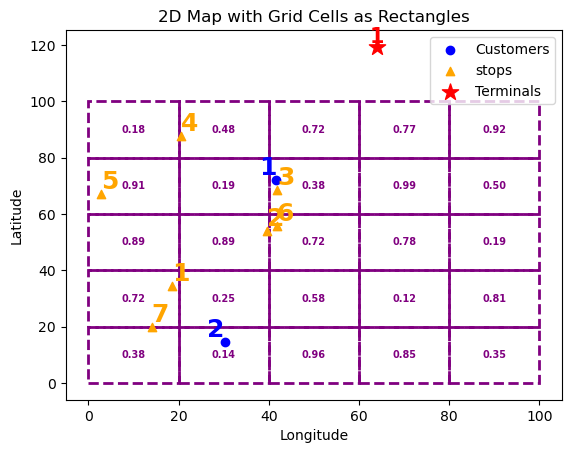

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()

# Customers (파란색 원)
ax.scatter(customers["longitude"], customers["latitude"],
           c="blue", marker="o", label="Customers")

# stops (주황색 삼각형)
ax.scatter(stops["longitude"], stops["latitude"],
           c="orange", marker="^", label="stops")

# Terminals (빨간색 별)
ax.scatter(terminals["longitude"], terminals["latitude"],
           c="red", marker="*", s=150, label="Terminals")

# Grid cells (보라색 사각형 테두리)
for _, row in grid_cells.iterrows():
    rect = patches.Rectangle(
        (row["center_longitude"] - 10, row["center_latitude"] - 10),  # 좌하단 꼭짓점
        20, 20,   # width, height
        linewidth=2, edgecolor="purple", facecolor="none", linestyle="--", zorder=0
    )
    ax.add_patch(rect)

    # complexity 값을 grid cell 중앙에 표시
    ax.text(
        row["center_longitude"], row["center_latitude"], 
        f"{row['complexity']:.2f}",
        color="purple",
        ha="center", va="center", fontsize=7, fontweight="bold"
    )

# Customers ID 라벨 (숫자만, 굵게)
for idx, row in customers.iterrows():
    label = idx.split("_")[-1]
    ax.text(row["longitude"], row["latitude"], label,
            color="blue", fontsize=18, ha="right", va="bottom",
            fontweight="bold")

# stops ID 라벨 (숫자만, 굵게)
for idx, row in stops.iterrows():
    label = idx.split("_")[-1]
    ax.text(row["longitude"], row["latitude"], label,
            color="orange", fontsize=18, ha="left", va="bottom",
            fontweight="bold")

# Terminals ID 라벨 (숫자만, 굵게)
for idx, row in terminals.iterrows():
    label = idx.split("_")[-1]
    ax.text(row["longitude"], row["latitude"], label,
            color="red", fontsize=15, ha="center", va="bottom",
            fontweight="bold")

# 라벨, 범례, 제목
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
ax.set_title("2D Map with Grid Cells as Rectangles")
# plt.savefig("map_with_grid_normal.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
# 복잡도를 고려하지 않은 버전 (복잡도 고려 x)

import pandas as pd
import numpy as np
import math
from datetime import datetime

# <Sets>
customers = pd.DataFrame(columns=["customer_id", "longitude", "latitude", "deadline"])
stops = pd.DataFrame(columns=["stop_id", "longitude", "latitude"])
ADRs = pd.DataFrame(columns=["ADR_id"])
grid_cells = pd.DataFrame(columns=["grid_cell_id", "center_longitude", "center_latitude", "complexity"])
terminals = pd.DataFrame(columns=["terminal_id", "longitude", "latitude"])

# 예시 데이터 삽입
np.random.seed(1)

for i in range(1, 3):
    lon = np.random.uniform(0, 100)
    lat = np.random.uniform(0, 100)
    # deadline = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    deadline = np.random.uniform(50, 100)
    customers.loc[len(customers)] = [f"customer_{i}", lon, lat, deadline]

number_of_stops = 7
for i in range(1, number_of_stops + 1):
    lon = np.random.uniform(0, 100)
    lat = np.random.uniform(0, 100)
    stops.loc[len(stops)] = [f"stop_{i}", lon, lat]

for i in range(1, 2):
    lon = np.random.uniform(0, 80)
    lat = np.random.uniform(100, 120)
    terminals.loc[len(terminals)] = [f"terminal_{i}", lon, lat]

cell_size = 20  # 반경 10 → 한 변 20
grid_cell_id = 1
for i in range(0, 100, cell_size):
    for j in range(0, 100, cell_size):
        center_lon = i + cell_size / 2
        center_lat = j + cell_size / 2
        complexity = np.random.uniform(0.1, 1.0)
        grid_cells.loc[len(grid_cells)] = [f"grid_cell_{grid_cell_id}", center_lon, center_lat, complexity]
        grid_cell_id += 1

for i in range(1, 20):
    ADRs.loc[len(ADRs)] = [f"ADR_{i}"]

customers.set_index("customer_id", inplace=True)
stops.set_index("stop_id", inplace=True)
ADRs.set_index("ADR_id", inplace=True)
grid_cells.set_index("grid_cell_id", inplace=True)
terminals.set_index("terminal_id", inplace=True)

# <Parameters>
ALPHA = 0.2
BETA = 0.2
VELOCITY_OF_TRUCK = 30 # V_t
VELOCITY_OF_ADR = 5 # V_r
CAPACITY_OF_TRUCK = 30 # Cap_t
def get_deadline(customer_id): # D_c
    return customers.loc[customer_id]['deadline']
def get_complexity(grid_cell_id): # Comp_p
    return grid_cells.loc[grid_cell_id]['complexity']
def get_distance_with_p(stop_id, customer_id, grid_cell_id): # d_ic_p
    # 좌표
    x1, y1 = stops.loc[stop_id][["longitude", "latitude"]]
    x2, y2 = customers.loc[customer_id][["longitude", "latitude"]]
    
    # grid cell 범위
    cell_size = 20
    cx, cy = grid_cells.loc[grid_cell_id][["center_longitude", "center_latitude"]]
    half = cell_size / 2
    xmin, xmax = cx - half, cx + half
    ymin, ymax = cy - half, cy + half

    # Liang-Barsky line clipping
    dx, dy = x2 - x1, y2 - y1
    p = [-dx, dx, -dy, dy]
    q = [x1 - xmin, xmax - x1, y1 - ymin, ymax - y1]

    u1, u2 = 0, 1
    for pi, qi in zip(p, q):
        if pi == 0:
            if qi < 0:
                return 0  # 평행 & 영역 밖
        else:
            t = qi / pi
            if pi < 0:
                u1 = max(u1, t)
            else:
                u2 = min(u2, t)

    if u1 > u2:  # 교차 없음
        return 0

    # 잘린 선분 좌표
    ix1, iy1 = x1 + u1 * dx, y1 + u1 * dy
    ix2, iy2 = x1 + u2 * dx, y1 + u2 * dy

    # 교차 구간 길이
    return math.sqrt((ix2 - ix1) ** 2 + (iy2 - iy1) ** 2)
def get_distance_from_stop_to_stop(from_stop_id, to_stop_id): # d_ij
    # Manhattan distance
    # return abs(stops.loc[from_stop_id]['longitude'] - stops.loc[to_stop_id]['longitude']) \
    #     + abs(stops.loc[from_stop_id]['latitude'] - stops.loc[to_stop_id]['latitude'])

    # Euclidean distance
    return math.sqrt((stops.loc[from_stop_id]['longitude'] - stops.loc[to_stop_id]['longitude']) ** 2
                     + (stops.loc[from_stop_id]['latitude'] - stops.loc[to_stop_id]['latitude']) ** 2)
def get_distance_from_terminal_to_stop(terminal_id, stop_id): # d_oj
    return math.sqrt((terminals.loc[terminal_id]['longitude'] - stops.loc[stop_id]['longitude']) ** 2
                     + (terminals.loc[terminal_id]['latitude'] - stops.loc[stop_id]['latitude']) ** 2)
def get_distance_from_stop_to_terminal(stop_id, terminal_id): # d_io
    return math.sqrt((stops.loc[stop_id]['longitude'] - terminals.loc[terminal_id]['longitude']) ** 2
                     + (stops.loc[stop_id]['latitude'] - terminals.loc[terminal_id]['latitude']) ** 2)
DROP_OFF_TIME = 0.5 # T_d
PICKUP_TIME = 1.0 # T_p
ADR_TIME = 0.3 # T_r
NUMBER_OF_CUSTOMERS = len(customers) # N_c
M = 10 ** 5

import gurobipy as gp
from gurobipy import GRB, quicksum

model = gp.Model('Last-mile Logistics with Two Trucks and ADRs')

# Decision variables
x_ij_d = model.addVars(terminals.index.tolist() + stops.index.tolist(), terminals.index.tolist() + stops.index.tolist(), vtype=GRB.BINARY, name="x_ij_d")
x_ij_p = model.addVars(terminals.index.tolist() + stops.index.tolist(), terminals.index.tolist() + stops.index.tolist(), vtype=GRB.BINARY, name="x_ij_p")
y_ic_r = model.addVars(stops.index.tolist(), customers.index.tolist(), ADRs.index.tolist(), vtype=GRB.BINARY, name="y_ic_r")
y_cj_r = model.addVars(customers.index.tolist(), stops.index.tolist(), ADRs.index.tolist(), vtype=GRB.BINARY, name="y_cj_r")

# Arbitrary variables
t_j_d = model.addVars(terminals.index.tolist() + stops.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="t_j_d")
t_j_p = model.addVars(terminals.index.tolist() + stops.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="t_j_p")
t_c_r = model.addVars(customers.index.tolist(), ADRs.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="t_c_r")

# Auxiliary variable
z_c_r = model.addVars(customers.index.tolist(), ADRs.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="z_c_r")

# Objective
# penalty_cost
penalty_cost = quicksum(z_c_r[c, r] for c in customers.index.tolist() for r in ADRs.index.tolist())
# trucks travel cost
trucks_travel_cost = quicksum(get_distance_from_stop_to_stop(i, j) * (x_ij_d[i, j] + x_ij_p[i, j]) 
                              for i in stops.index.tolist() for j in stops.index.tolist()) + \
                    quicksum(get_distance_from_terminal_to_stop(i, j) * (x_ij_d[i, j] + x_ij_p[i, j]) 
                             for i in terminals.index.tolist() for j in stops.index.tolist()) + \
                    quicksum(get_distance_from_stop_to_terminal(i, j) * (x_ij_d[i, j] + x_ij_p[i, j]) 
                             for i in stops.index.tolist() for j in terminals.index.tolist())
# ADRs travel cost
stop_to_customer = quicksum(y_ic_r[i, c, r] * get_distance_with_p(i, c, p)
                        for i in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist() for p in grid_cells.index.tolist())
customer_to_stop = quicksum(y_cj_r[c, j, r] * get_distance_with_p(j, c, p)
                        for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist() for p in grid_cells.index.tolist())
ADRs_travel_cost = stop_to_customer + customer_to_stop

model.setObjective(penalty_cost + ALPHA * trucks_travel_cost + BETA * ADRs_travel_cost, GRB.MINIMIZE)

# Constraints
model.addConstrs(z_c_r[c, r] >= t_c_r[c, r] - get_deadline(c) for c in customers.index.tolist() for r in ADRs.index.tolist()) # 2

model.addConstrs(quicksum(x_ij_d[i, j] for j in terminals.index.tolist() + stops.index.tolist()) <= 1 # 3
                 for i in terminals.index.tolist() + stops.index.tolist())

model.addConstrs(quicksum(x_ij_p[i, j] for j in terminals.index.tolist() + stops.index.tolist()) <= 1 # 4
                 for i in terminals.index.tolist() + stops.index.tolist())

model.addConstr(quicksum(x_ij_d[o, j] for o in terminals.index.tolist() for j in stops.index.tolist()) == 1) # 5

model.addConstr(quicksum(x_ij_p[o, j] for o in terminals.index.tolist() for j in stops.index.tolist()) == 1) # 6

model.addConstr(quicksum(x_ij_d[i, o] for i in stops.index.tolist() for o in terminals.index.tolist()) == 1) # 7

model.addConstr(quicksum(x_ij_p[i, o] for i in stops.index.tolist() for o in terminals.index.tolist()) == 1) # 8

model.addConstrs(quicksum(x_ij_d[i, j] for i in terminals.index.tolist() + stops.index.tolist() if i != j) == # 9
                 quicksum(x_ij_d[j, k] for k in terminals.index.tolist() + stops.index.tolist() if k != j)
                 for j in stops.index.tolist())

model.addConstrs(quicksum(x_ij_p[i, j] for i in terminals.index.tolist() + stops.index.tolist() if i != j) == # 10
                 quicksum(x_ij_p[j, k] for k in terminals.index.tolist() + stops.index.tolist() if k != j)
                 for j in stops.index.tolist())

model.addConstr(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist()) # 11
                <= CAPACITY_OF_TRUCK)

model.addConstrs(quicksum(y_ic_r[i, c, r] for c in customers.index.tolist() for r in ADRs.index.tolist()) >= # 12
                 quicksum(x_ij_d[j, i] for j in terminals.index.tolist() + stops.index.tolist() if i != j)
                 for i in stops.index.tolist())

model.addConstrs(quicksum(x_ij_p[i, j] for i in terminals.index.tolist() + stops.index.tolist() if i != j) >= # 13
                 quicksum(y_cj_r[c, j, r] for c in customers.index.tolist() for r in ADRs.index.tolist()) / NUMBER_OF_CUSTOMERS
                 for j in stops.index.tolist())

model.addConstrs(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist()) == # 14
                 quicksum(y_cj_r[c, j, r] for j in stops.index.tolist())
                 for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist() for r in ADRs.index.tolist()) == 1 # 15
                 for c in customers.index.tolist())

model.addConstrs(t_j_d[o] == 0 for o in terminals.index.tolist()) # 16

model.addConstrs(t_j_d[j] >= t_j_d[o] + get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK # 17-1
                 + DROP_OFF_TIME
                 - M * (1 - x_ij_d[o, j])
                 for o in terminals.index.tolist() for j in stops.index.tolist())
model.addConstrs(t_j_d[j] >= t_j_d[i] + get_distance_from_stop_to_stop(i, j) / VELOCITY_OF_TRUCK # 17-2
                 + DROP_OFF_TIME
                 - M * (1 - x_ij_d[i, j])
                 for i in stops.index.tolist() for j in stops.index.tolist())

# 도로 복잡도를 고려하지 않는 경우
model.addConstrs(t_c_r[c, r] >= t_j_d[i] # 18
                 + quicksum(get_distance_with_p(i, c, p) / VELOCITY_OF_ADR for p in grid_cells.index.tolist())
                 + ADR_TIME
                 - M * (1 - y_ic_r[i, c, r])
                 for i in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[o] <= t_c_r[c, r] # 19
                 + quicksum(get_distance_with_p(j, c, p) / VELOCITY_OF_ADR for p in grid_cells.index.tolist())
                 - get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK
                 + M * (1 - y_cj_r[c, j, r])
                 for o in terminals.index.tolist() for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[o] >= t_c_r[c, r] # 20
                 + quicksum(get_distance_with_p(j, c, p) / VELOCITY_OF_ADR for p in grid_cells.index.tolist())
                 - get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK
                 - M * (1 - y_cj_r[c, j, r])
                 for o in terminals.index.tolist() for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[j] >= t_c_r[c, r] # 21
                 + quicksum(get_distance_with_p(j, c, p) / VELOCITY_OF_ADR / get_complexity(p) for p in grid_cells.index.tolist())
                 + PICKUP_TIME
                 - M * (1 - y_cj_r[c, j, r])
                 for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[j] >= t_j_p[o] # 22-1
                 + get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK
                 + PICKUP_TIME
                 - M * (1 - x_ij_p[o, j])
                 for o in terminals.index.tolist() for j in stops.index.tolist())
model.addConstrs(t_j_p[j] >= t_j_p[i] # 22-2
                 + get_distance_from_stop_to_stop(i, j) / VELOCITY_OF_TRUCK
                 + PICKUP_TIME
                 - M * (1 - x_ij_p[i, j])
                 for i in stops.index.tolist() for j in stops.index.tolist() if i != j)

model.addConstrs(x_ij_d[i, j] + x_ij_d[j, i] <= 1 # 23
                 for i in stops.index.tolist() for j in stops.index.tolist())

model.addConstrs(x_ij_p[i, j] + x_ij_p[j, i] <= 1 # 24
                 for i in stops.index.tolist() for j in stops.index.tolist())

model.addConstrs(quicksum(x_ij_d[j, i] for j in terminals.index.tolist() + stops.index.tolist() if j != i) >= # 25
                 quicksum(y_ic_r[i, c, r] for c in customers.index.tolist() for r in ADRs.index.tolist()) / NUMBER_OF_CUSTOMERS
                 for i in stops.index.tolist())

model.addConstrs(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist() for c in customers.index.tolist()) <= 1 # 26
                 for r in ADRs.index.tolist())

model.optimize()

if model.status in (GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL):
    print('-' * 50)
    
    print("Number of customers:", NUMBER_OF_CUSTOMERS)
    print("Number of ADRs:", len(ADRs))
    
    print('-' * 50)
    
    print("Objective:", model.objVal)
    
    print('-' * 50)

    # print z_c_r values
    print("(penalty cost) z_c_r:")
    for c in customers.index.tolist():
        for r in ADRs.index.tolist():
            v = model.getVarByName(f"z_c_r[{c},{r}]")
            if v is not None and v.X > 0.5:
                print((c, r), '=', v.X)

    print('-' * 50)
    
    # print selected arcs x_ij_d
    print("Selected x_ij_d arcs:")
    for i in terminals.index.tolist() + stops.index.tolist():
        for j in terminals.index.tolist() + stops.index.tolist():
            v = model.getVarByName(f"x_ij_d[{i},{j}]") if f"x_ij_d[{i},{j}]" in [v.VarName for v in model.getVars()] else None
            if v is not None and v.X > 0.5:
                print(" ", i, "->", j)

    print('-' * 50)
    
    # print some y_ic_r
    print("Selected y_ic_r:")
    for i in stops.index.tolist():
        for c in customers.index.tolist():
            for r in ADRs.index.tolist():
                vname = f"y_ic_r[{i},{c},{r}]"
                if vname in [v.VarName for v in model.getVars()]:
                    v = model.getVarByName(vname)
                    if v.X > 0.5:
                        print(" ", (i, c, r))

    print('-' * 50)
    
    # print some y_cj_r
    print("Selected y_cj_r:")
    for c in customers.index.tolist():
        for j in stops.index.tolist():
            for r in ADRs.index.tolist():
                vname = f"y_cj_r[{c},{j},{r}]"
                if vname in [v.VarName for v in model.getVars()]:
                    v = model.getVarByName(vname)
                    if v.X > 0.5:
                        print(" ", (c, j, r))
    
    print('-' * 50)
    
    # print selected arcs x_ij_d
    print("Selected x_ij_p arcs:")
    for i in terminals.index.tolist() + stops.index.tolist():
        for j in terminals.index.tolist() + stops.index.tolist():
            v = model.getVarByName(f"x_ij_p[{i},{j}]") if f"x_ij_p[{i},{j}]" in [v.VarName for v in model.getVars()] else None
            if v is not None and v.X > 0.5:
                print(" ", i, "->", j)
    
    print('-' * 50)

    # print ADRs times
    print("t_c_r:")
    for c in customers.index.tolist():
        for j in ADRs.index.tolist():
            v = model.getVarByName(f"t_c_r[{c},{j}]")
            if v is not None and v.X > 0.5:
                print(f" t_c_r[{c},{j}] = {v.X:.2f};")

    print('-' * 50)
    
    # print trucks times
    print("t_j_d:")
    print(" t_j_d[terminal_1] = 0.00")
    for node in stops.index.tolist():
        tdv = model.getVarByName(f"t_j_d[{node}]")
        if tdv is not None and tdv.X > 0: 
            print(f" t_j_d[{node}] = {tdv.X:.2f}")

    print("t_j_p:")
    for node in terminals.index.tolist() + stops.index.tolist():
        tpv = model.getVarByName(f"t_j_p[{node}]")
        if tpv is not None and tpv.X > 0: 
            print(f" t_j_p[{node}] = {tpv.X:.2f}")

    # print objective values
    penalty_val = sum(model.getVarByName(f"z_c_r[{c},{r}]").X
                      for c in customers.index.tolist()
                      for r in ADRs.index.tolist())

    trucks_val = sum(get_distance_from_stop_to_stop(i, j) *
                     (model.getVarByName(f"x_ij_d[{i},{j}]").X + model.getVarByName(f"x_ij_p[{i},{j}]").X)
                     for i in stops.index.tolist() for j in stops.index.tolist()) \
                 + sum(get_distance_from_terminal_to_stop(i, j) *
                     (model.getVarByName(f"x_ij_d[{i},{j}]").X + model.getVarByName(f"x_ij_p[{i},{j}]").X)
                     for i in terminals.index.tolist() for j in stops.index.tolist()) \
                 + sum(get_distance_from_stop_to_terminal(i, j) *
                     (model.getVarByName(f"x_ij_d[{i},{j}]").X + model.getVarByName(f"x_ij_p[{i},{j}]").X)
                     for i in stops.index.tolist() for j in terminals.index.tolist())

    stop_to_customer_val = sum(get_distance_with_p(i, c, p) * model.getVarByName(f"y_ic_r[{i},{c},{r}]").X
                            for i in stops.index.tolist() for c in customers.index.tolist()
                            for r in ADRs.index.tolist() for p in grid_cells.index.tolist())

    customer_to_stop_val = sum(get_distance_with_p(j, c, p) * model.getVarByName(f"y_cj_r[{c},{j},{r}]").X
                            for j in stops.index.tolist() for c in customers.index.tolist()
                            for r in ADRs.index.tolist() for p in grid_cells.index.tolist())
    
    ADRs_val = stop_to_customer_val + customer_to_stop_val

    print("="*50)
    print("Decomposed Objective values")
    print(f"Penalty cost       = {penalty_val:.2f}")
    print(f"Trucks travel cost = {trucks_val:.2f}")
    print(f"ADRs travel cost   = {ADRs_val:.2f}")
    print(f"Objective (check)  = {penalty_val + ALPHA*trucks_val + BETA*ADRs_val:.2f}")
    print("="*50)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1421 rows, 752 columns and 6379 nonzeros
Model fingerprint: 0xba1cfc7a
Variable types: 92 continuous, 660 integer (660 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+05]
  Objective range  [6e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 67 rows and 17 columns
Presolve time: 0.01s
Presolved: 1354 rows, 735 columns, 5972 nonzeros
Variable types: 91 continuous, 644 integer (644 binary)
Found heuristic solution: objective 103.8578094

Root relaxation: objective 5.653660e+01, 65 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   56.53660    0   12  103.85781   56.53660

In [10]:
# 분석 버전

import pandas as pd
import numpy as np
import math
from datetime import datetime

# <Sets>
customers = pd.DataFrame(columns=["customer_id", "longitude", "latitude", "deadline"])
stops = pd.DataFrame(columns=["stop_id", "longitude", "latitude"])
ADRs = pd.DataFrame(columns=["ADR_id"])
grid_cells = pd.DataFrame(columns=["grid_cell_id", "center_longitude", "center_latitude", "complexity"])
terminals = pd.DataFrame(columns=["terminal_id", "longitude", "latitude"])

# 예시 데이터 삽입
np.random.seed(1)

for i in range(1, 3):
    lon = np.random.uniform(0, 100)
    lat = np.random.uniform(0, 100)
    # deadline = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    deadline = np.random.uniform(50, 100)
    customers.loc[len(customers)] = [f"customer_{i}", lon, lat, deadline]

number_of_stops = 7
for i in range(1, number_of_stops + 1):
    lon = np.random.uniform(0, 100)
    lat = np.random.uniform(0, 100)
    stops.loc[len(stops)] = [f"stop_{i}", lon, lat]

for i in range(1, 2):
    lon = np.random.uniform(0, 80)
    lat = np.random.uniform(100, 120)
    terminals.loc[len(terminals)] = [f"terminal_{i}", lon, lat]

cell_size = 20  # 반경 10 → 한 변 20
grid_cell_id = 1
for i in range(0, 100, cell_size):
    for j in range(0, 100, cell_size):
        center_lon = i + cell_size / 2
        center_lat = j + cell_size / 2
        complexity = np.random.uniform(0.1, 1.0)
        grid_cells.loc[len(grid_cells)] = [f"grid_cell_{grid_cell_id}", center_lon, center_lat, complexity]
        grid_cell_id += 1

for i in range(1, 20):
    ADRs.loc[len(ADRs)] = [f"ADR_{i}"]

customers.set_index("customer_id", inplace=True)
stops.set_index("stop_id", inplace=True)
ADRs.set_index("ADR_id", inplace=True)
grid_cells.set_index("grid_cell_id", inplace=True)
terminals.set_index("terminal_id", inplace=True)



###########################
stops = stops.loc[["stop_3"]]



###########################


# <Parameters>
ALPHA = 0.2
BETA = 0.2
VELOCITY_OF_TRUCK = 30 # V_t
VELOCITY_OF_ADR = 5 # V_r
CAPACITY_OF_TRUCK = 30 # Cap_t
def get_deadline(customer_id): # D_c
    return customers.loc[customer_id]['deadline']
def get_complexity(grid_cell_id): # Comp_p
    return grid_cells.loc[grid_cell_id]['complexity']
def get_distance_with_p(stop_id, customer_id, grid_cell_id): # d_ic_p
    # 좌표
    x1, y1 = stops.loc[stop_id][["longitude", "latitude"]]
    x2, y2 = customers.loc[customer_id][["longitude", "latitude"]]
    
    # grid cell 범위
    cell_size = 20
    cx, cy = grid_cells.loc[grid_cell_id][["center_longitude", "center_latitude"]]
    half = cell_size / 2
    xmin, xmax = cx - half, cx + half
    ymin, ymax = cy - half, cy + half

    # Liang-Barsky line clipping
    dx, dy = x2 - x1, y2 - y1
    p = [-dx, dx, -dy, dy]
    q = [x1 - xmin, xmax - x1, y1 - ymin, ymax - y1]

    u1, u2 = 0, 1
    for pi, qi in zip(p, q):
        if pi == 0:
            if qi < 0:
                return 0  # 평행 & 영역 밖
        else:
            t = qi / pi
            if pi < 0:
                u1 = max(u1, t)
            else:
                u2 = min(u2, t)

    if u1 > u2:  # 교차 없음
        return 0

    # 잘린 선분 좌표
    ix1, iy1 = x1 + u1 * dx, y1 + u1 * dy
    ix2, iy2 = x1 + u2 * dx, y1 + u2 * dy

    # 교차 구간 길이
    return math.sqrt((ix2 - ix1) ** 2 + (iy2 - iy1) ** 2)
def get_distance_from_stop_to_stop(from_stop_id, to_stop_id): # d_ij
    # Manhattan distance
    # return abs(stops.loc[from_stop_id]['longitude'] - stops.loc[to_stop_id]['longitude']) \
    #     + abs(stops.loc[from_stop_id]['latitude'] - stops.loc[to_stop_id]['latitude'])

    # Euclidean distance
    return math.sqrt((stops.loc[from_stop_id]['longitude'] - stops.loc[to_stop_id]['longitude']) ** 2
                     + (stops.loc[from_stop_id]['latitude'] - stops.loc[to_stop_id]['latitude']) ** 2)
def get_distance_from_terminal_to_stop(terminal_id, stop_id): # d_oj
    return math.sqrt((terminals.loc[terminal_id]['longitude'] - stops.loc[stop_id]['longitude']) ** 2
                     + (terminals.loc[terminal_id]['latitude'] - stops.loc[stop_id]['latitude']) ** 2)
def get_distance_from_stop_to_terminal(stop_id, terminal_id): # d_io
    return math.sqrt((stops.loc[stop_id]['longitude'] - terminals.loc[terminal_id]['longitude']) ** 2
                     + (stops.loc[stop_id]['latitude'] - terminals.loc[terminal_id]['latitude']) ** 2)
DROP_OFF_TIME = 0.5 # T_d
PICKUP_TIME = 1.0 # T_p
ADR_TIME = 0.3 # T_r
NUMBER_OF_CUSTOMERS = len(customers) # N_c
M = 10 ** 5

import gurobipy as gp
from gurobipy import GRB, quicksum

model = gp.Model('Last-mile Logistics with Two Trucks and ADRs')

# Decision variables
x_ij_d = model.addVars(terminals.index.tolist() + stops.index.tolist(), terminals.index.tolist() + stops.index.tolist(), vtype=GRB.BINARY, name="x_ij_d")
x_ij_p = model.addVars(terminals.index.tolist() + stops.index.tolist(), terminals.index.tolist() + stops.index.tolist(), vtype=GRB.BINARY, name="x_ij_p")
y_ic_r = model.addVars(stops.index.tolist(), customers.index.tolist(), ADRs.index.tolist(), vtype=GRB.BINARY, name="y_ic_r")
y_cj_r = model.addVars(customers.index.tolist(), stops.index.tolist(), ADRs.index.tolist(), vtype=GRB.BINARY, name="y_cj_r")

# Arbitrary variables
t_j_d = model.addVars(terminals.index.tolist() + stops.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="t_j_d")
t_j_p = model.addVars(terminals.index.tolist() + stops.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="t_j_p")
t_c_r = model.addVars(customers.index.tolist(), ADRs.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="t_c_r")

# Auxiliary variable
z_c_r = model.addVars(customers.index.tolist(), ADRs.index.tolist(), lb=0.0, vtype=GRB.CONTINUOUS, name="z_c_r")

# Objective
# penalty_cost
penalty_cost = quicksum(z_c_r[c, r] for c in customers.index.tolist() for r in ADRs.index.tolist())
# trucks travel cost
trucks_travel_cost = quicksum(get_distance_from_stop_to_stop(i, j) * (x_ij_d[i, j] + x_ij_p[i, j]) 
                              for i in stops.index.tolist() for j in stops.index.tolist()) + \
                    quicksum(get_distance_from_terminal_to_stop(i, j) * (x_ij_d[i, j] + x_ij_p[i, j]) 
                             for i in terminals.index.tolist() for j in stops.index.tolist()) + \
                    quicksum(get_distance_from_stop_to_terminal(i, j) * (x_ij_d[i, j] + x_ij_p[i, j]) 
                             for i in stops.index.tolist() for j in terminals.index.tolist())
# ADRs travel cost
stop_to_customer = quicksum(y_ic_r[i, c, r] * get_distance_with_p(i, c, p)
                        for i in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist() for p in grid_cells.index.tolist())
customer_to_stop = quicksum(y_cj_r[c, j, r] * get_distance_with_p(j, c, p)
                        for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist() for p in grid_cells.index.tolist())
ADRs_travel_cost = stop_to_customer + customer_to_stop

model.setObjective(penalty_cost + ALPHA * trucks_travel_cost + BETA * ADRs_travel_cost, GRB.MINIMIZE)

# Constraints
model.addConstrs(z_c_r[c, r] >= t_c_r[c, r] - get_deadline(c) for c in customers.index.tolist() for r in ADRs.index.tolist()) # 2

model.addConstrs(quicksum(x_ij_d[i, j] for j in terminals.index.tolist() + stops.index.tolist()) <= 1 # 3
                 for i in terminals.index.tolist() + stops.index.tolist())

model.addConstrs(quicksum(x_ij_p[i, j] for j in terminals.index.tolist() + stops.index.tolist()) <= 1 # 4
                 for i in terminals.index.tolist() + stops.index.tolist())

model.addConstr(quicksum(x_ij_d[o, j] for o in terminals.index.tolist() for j in stops.index.tolist()) == 1) # 5

model.addConstr(quicksum(x_ij_p[o, j] for o in terminals.index.tolist() for j in stops.index.tolist()) == 1) # 6

model.addConstr(quicksum(x_ij_d[i, o] for i in stops.index.tolist() for o in terminals.index.tolist()) == 1) # 7

model.addConstr(quicksum(x_ij_p[i, o] for i in stops.index.tolist() for o in terminals.index.tolist()) == 1) # 8

model.addConstrs(quicksum(x_ij_d[i, j] for i in terminals.index.tolist() + stops.index.tolist() if i != j) == # 9
                 quicksum(x_ij_d[j, k] for k in terminals.index.tolist() + stops.index.tolist() if k != j)
                 for j in stops.index.tolist())

model.addConstrs(quicksum(x_ij_p[i, j] for i in terminals.index.tolist() + stops.index.tolist() if i != j) == # 10
                 quicksum(x_ij_p[j, k] for k in terminals.index.tolist() + stops.index.tolist() if k != j)
                 for j in stops.index.tolist())

model.addConstr(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist()) # 11
                <= CAPACITY_OF_TRUCK)

model.addConstrs(quicksum(y_ic_r[i, c, r] for c in customers.index.tolist() for r in ADRs.index.tolist()) >= # 12
                 quicksum(x_ij_d[j, i] for j in terminals.index.tolist() + stops.index.tolist() if i != j)
                 for i in stops.index.tolist())

model.addConstrs(quicksum(x_ij_p[i, j] for i in terminals.index.tolist() + stops.index.tolist() if i != j) >= # 13
                 quicksum(y_cj_r[c, j, r] for c in customers.index.tolist() for r in ADRs.index.tolist()) / NUMBER_OF_CUSTOMERS
                 for j in stops.index.tolist())

model.addConstrs(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist()) == # 14
                 quicksum(y_cj_r[c, j, r] for j in stops.index.tolist())
                 for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist() for r in ADRs.index.tolist()) == 1 # 15
                 for c in customers.index.tolist())

model.addConstrs(t_j_d[o] == 0 for o in terminals.index.tolist()) # 16

model.addConstrs(t_j_d[j] >= t_j_d[o] + get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK # 17-1
                 + DROP_OFF_TIME
                 - M * (1 - x_ij_d[o, j])
                 for o in terminals.index.tolist() for j in stops.index.tolist())
model.addConstrs(t_j_d[j] >= t_j_d[i] + get_distance_from_stop_to_stop(i, j) / VELOCITY_OF_TRUCK # 17-2
                 + DROP_OFF_TIME
                 - M * (1 - x_ij_d[i, j])
                 for i in stops.index.tolist() for j in stops.index.tolist())

# 도로 복잡도를 고려하는 경우
model.addConstrs(t_c_r[c, r] >= t_j_d[i] # 18
                 + quicksum(get_distance_with_p(i, c, p) / VELOCITY_OF_ADR / get_complexity(p) for p in grid_cells.index.tolist())
                 + ADR_TIME
                 - M * (1 - y_ic_r[i, c, r])
                 for i in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[o] <= t_c_r[c, r] # 19
                 + quicksum(get_distance_with_p(j, c, p) / VELOCITY_OF_ADR / get_complexity(p) for p in grid_cells.index.tolist())
                 - get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK
                 + M * (1 - y_cj_r[c, j, r])
                 for o in terminals.index.tolist() for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[o] >= t_c_r[c, r] # 20
                 + quicksum(get_distance_with_p(j, c, p) / VELOCITY_OF_ADR / get_complexity(p) for p in grid_cells.index.tolist())
                 - get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK
                 - M * (1 - y_cj_r[c, j, r])
                 for o in terminals.index.tolist() for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[j] >= t_c_r[c, r] # 21
                 + quicksum(get_distance_with_p(j, c, p) / VELOCITY_OF_ADR / get_complexity(p) for p in grid_cells.index.tolist())
                 + PICKUP_TIME
                 - M * (1 - y_cj_r[c, j, r])
                 for j in stops.index.tolist() for c in customers.index.tolist() for r in ADRs.index.tolist())

model.addConstrs(t_j_p[j] >= t_j_p[o] # 22-1
                 + get_distance_from_terminal_to_stop(o, j) / VELOCITY_OF_TRUCK
                 + PICKUP_TIME
                 - M * (1 - x_ij_p[o, j])
                 for o in terminals.index.tolist() for j in stops.index.tolist())
model.addConstrs(t_j_p[j] >= t_j_p[i] # 22-2
                 + get_distance_from_stop_to_stop(i, j) / VELOCITY_OF_TRUCK
                 + PICKUP_TIME
                 - M * (1 - x_ij_p[i, j])
                 for i in stops.index.tolist() for j in stops.index.tolist() if i != j)

model.addConstrs(x_ij_d[i, j] + x_ij_d[j, i] <= 1 # 23
                 for i in stops.index.tolist() for j in stops.index.tolist())

model.addConstrs(x_ij_p[i, j] + x_ij_p[j, i] <= 1 # 24
                 for i in stops.index.tolist() for j in stops.index.tolist())

model.addConstrs(quicksum(x_ij_d[j, i] for j in terminals.index.tolist() + stops.index.tolist() if j != i) >= # 25
                 quicksum(y_ic_r[i, c, r] for c in customers.index.tolist() for r in ADRs.index.tolist()) / NUMBER_OF_CUSTOMERS
                 for i in stops.index.tolist())

model.addConstrs(quicksum(y_ic_r[i, c, r] for i in stops.index.tolist() for c in customers.index.tolist()) <= 1 # 26
                 for r in ADRs.index.tolist())

model.optimize()

if model.status in (GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL):
    print('-' * 50)
    
    print("Number of customers:", NUMBER_OF_CUSTOMERS)
    print("Number of ADRs:", len(ADRs))
    
    print('-' * 50)
    
    print("Objective:", model.objVal)
    
    print('-' * 50)

    # print z_c_r values
    print("(penalty cost) z_c_r:")
    for c in customers.index.tolist():
        for r in ADRs.index.tolist():
            v = model.getVarByName(f"z_c_r[{c},{r}]")
            if v is not None and v.X > 0.5:
                print((c, r), '=', v.X)

    print('-' * 50)
    
    # print selected arcs x_ij_d
    print("Selected x_ij_d arcs:")
    for i in terminals.index.tolist() + stops.index.tolist():
        for j in terminals.index.tolist() + stops.index.tolist():
            v = model.getVarByName(f"x_ij_d[{i},{j}]") if f"x_ij_d[{i},{j}]" in [v.VarName for v in model.getVars()] else None
            if v is not None and v.X > 0.5:
                print(" ", i, "->", j)

    print('-' * 50)
    
    # print some y_ic_r
    print("Selected y_ic_r:")
    for i in stops.index.tolist():
        for c in customers.index.tolist():
            for r in ADRs.index.tolist():
                vname = f"y_ic_r[{i},{c},{r}]"
                if vname in [v.VarName for v in model.getVars()]:
                    v = model.getVarByName(vname)
                    if v.X > 0.5:
                        print(" ", (i, c, r))

    print('-' * 50)
    
    # print some y_cj_r
    print("Selected y_cj_r:")
    for c in customers.index.tolist():
        for j in stops.index.tolist():
            for r in ADRs.index.tolist():
                vname = f"y_cj_r[{c},{j},{r}]"
                if vname in [v.VarName for v in model.getVars()]:
                    v = model.getVarByName(vname)
                    if v.X > 0.5:
                        print(" ", (c, j, r))
    
    print('-' * 50)
    
    # print selected arcs x_ij_d
    print("Selected x_ij_p arcs:")
    for i in terminals.index.tolist() + stops.index.tolist():
        for j in terminals.index.tolist() + stops.index.tolist():
            v = model.getVarByName(f"x_ij_p[{i},{j}]") if f"x_ij_p[{i},{j}]" in [v.VarName for v in model.getVars()] else None
            if v is not None and v.X > 0.5:
                print(" ", i, "->", j)
    
    print('-' * 50)

    # print ADRs times
    print("t_c_r:")
    for c in customers.index.tolist():
        for j in ADRs.index.tolist():
            v = model.getVarByName(f"t_c_r[{c},{j}]")
            if v is not None and v.X > 0.5:
                print(f" t_c_r[{c},{j}] = {v.X:.2f};")

    print('-' * 50)
    
    # print trucks times
    print("t_j_d:")
    print(" t_j_d[terminal_1] = 0.00")
    for node in stops.index.tolist():
        tdv = model.getVarByName(f"t_j_d[{node}]")
        if tdv is not None and tdv.X > 0: 
            print(f" t_j_d[{node}] = {tdv.X:.2f}")

    print("t_j_p:")
    for node in terminals.index.tolist() + stops.index.tolist():
        tpv = model.getVarByName(f"t_j_p[{node}]")
        if tpv is not None and tpv.X > 0: 
            print(f" t_j_p[{node}] = {tpv.X:.2f}")

    # print objective values
    penalty_val = sum(model.getVarByName(f"z_c_r[{c},{r}]").X
                      for c in customers.index.tolist()
                      for r in ADRs.index.tolist())

    trucks_val = sum(get_distance_from_stop_to_stop(i, j) *
                     (model.getVarByName(f"x_ij_d[{i},{j}]").X + model.getVarByName(f"x_ij_p[{i},{j}]").X)
                     for i in stops.index.tolist() for j in stops.index.tolist()) \
                 + sum(get_distance_from_terminal_to_stop(i, j) *
                     (model.getVarByName(f"x_ij_d[{i},{j}]").X + model.getVarByName(f"x_ij_p[{i},{j}]").X)
                     for i in terminals.index.tolist() for j in stops.index.tolist()) \
                 + sum(get_distance_from_stop_to_terminal(i, j) *
                     (model.getVarByName(f"x_ij_d[{i},{j}]").X + model.getVarByName(f"x_ij_p[{i},{j}]").X)
                     for i in stops.index.tolist() for j in terminals.index.tolist())

    stop_to_customer_val = sum(get_distance_with_p(i, c, p) * model.getVarByName(f"y_ic_r[{i},{c},{r}]").X
                            for i in stops.index.tolist() for c in customers.index.tolist()
                            for r in ADRs.index.tolist() for p in grid_cells.index.tolist())

    customer_to_stop_val = sum(get_distance_with_p(j, c, p) * model.getVarByName(f"y_cj_r[{c},{j},{r}]").X
                            for j in stops.index.tolist() for c in customers.index.tolist()
                            for r in ADRs.index.tolist() for p in grid_cells.index.tolist())
    
    ADRs_val = stop_to_customer_val + customer_to_stop_val

    print("="*50)
    print("Decomposed Objective values")
    print(f"Penalty cost       = {penalty_val:.2f}")
    print(f"Trucks travel cost = {trucks_val:.2f}")
    print(f"ADRs travel cost   = {ADRs_val:.2f}")
    print(f"Objective (check)  = {penalty_val + ALPHA*trucks_val + BETA*ADRs_val:.2f}")
    print("="*50)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 269 rows, 164 columns and 865 nonzeros
Model fingerprint: 0x4caa6381
Variable types: 80 continuous, 84 integer (84 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+05]
  Objective range  [7e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 96 rows and 49 columns
Presolve time: 0.00s
Presolved: 173 rows, 115 columns, 456 nonzeros
Variable types: 77 continuous, 38 integer (38 binary)
Found heuristic solution: objective 85.4365150

Root relaxation: objective 6.781060e+01, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   67.81060    0    4   85.43651   67.81060  20.6%   